In [2]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# setando o tema do seaborn para os gráficos
sns.set_theme()

In [4]:
# carregando o arquivo em um dataframe

dir = 'dados'
file = 'dataset.csv'
df = pd.read_csv(f'{dir}/{file}')
df.head()

,ID_Pedido,Data_Pedido,ID_Cliente,Segmento,Pais,Cidade,Estado,ID_Produto,Categoria,SubCategoria,Valor_Venda
0,CA-2017-152156,08/11/2017,CG-12520,Consumer,United States,Henderson,Kentucky,FUR-BO-10001798,Furniture,Bookcases,261.9600
1,CA-2017-152156,08/11/2017,CG-12520,Consumer,United States,Henderson,Kentucky,FUR-CH-10000454,Furniture,Chairs,731.9400
2,CA-2017-138688,12/06/2017,DV-13045,Corporate,United States,Los Angeles,California,OFF-LA-10000240,Office Supplies,Labels,14.6200
3,US-2016-108966,11/10/2016,SO-20335,Consumer,United States,Fort Lauderdale,Florida,FUR-TA-10000577,Furniture,Tables,957.5775
4,US-2016-108966,11/10/2016,SO-20335,Consumer,United States,Fort Lauderdale,Florida,OFF-ST-10000760,Office Supplies,Storage,22.3680


In [5]:
# dimensoes do dataframe
df.shape

(9700, 11)

In [6]:
# infos gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9700 entries, 0 to 9699
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID_Pedido     9700 non-null   object 
 1   Data_Pedido   9700 non-null   object 
 2   ID_Cliente    9700 non-null   object 
 3   Segmento      9700 non-null   object 
 4   Pais          9700 non-null   object 
 5   Cidade        9700 non-null   object 
 6   Estado        9700 non-null   object 
 7   ID_Produto    9700 non-null   object 
 8   Categoria     9700 non-null   object 
 9   SubCategoria  9700 non-null   object 
 10  Valor_Venda   9700 non-null   float64
dtypes: float64(1), object(10)
memory usage: 833.7+ KB


In [7]:
# obtendo estatisticas rápidas de campos numéricos
df.describe()

,Valor_Venda
count,9700.000000
mean,230.469892
std,627.504252
min,0.444000
25%,17.248000
50%,54.272000
75%,209.932500
max,22638.480000


In [8]:
# verificando se há nulls em alguma coluna
df.isnull().sum()

ID_Pedido       0
Data_Pedido     0
ID_Cliente      0
Segmento        0
Pais            0
Cidade          0
Estado          0
ID_Produto      0
Categoria       0
SubCategoria    0
Valor_Venda     0
dtype: int64

In [9]:
# checando se há duplicatas
df.duplicated().sum()

# se houvesse, poderiam ser encontradas usando: 
# df[df.duplicated()]

np.int64(0)

## Pergunta de Negócio 1:

### Qual Cidade com Maior Valor de Venda de Produtos da Categoria 'Office Supplies'?

In [10]:
# calculando o total de vendas da categoria 'Office Supplies'
total_vendas = df.query("Categoria == 'Office Supplies'")['Valor_Venda'].sum()

# rankeando as cidades
df.query("Categoria == 'Office Supplies'")[['Cidade', 'Valor_Venda']].groupby(by='Cidade').sum()\
                                                                                          .sort_values(by='Valor_Venda', ascending=False)\
                                                                                          .reset_index()\
                                                                                          .sort_values(by='Valor_Venda', ascending=False)\
                                                                                          .assign(Percentual = lambda row: row['Valor_Venda'] * 100 / total_vendas)\
                                                                                          .head(1)
                                                                                          

,Cidade,Valor_Venda,Percentual
0,New York City,68362.814,9.834993


A cidade com maior valor de venda de produtos da categoria 'Office Supplies' é New York City, com cerca de $68.000 em vendas, representando aproxidamente 10% do total de vendas desta categoria.

## Pergunta de Negócio 2:

### Qual o Total de Vendas por mês/ano do Pedido?

Demonstre o resultado através de um gráfico de linhas.

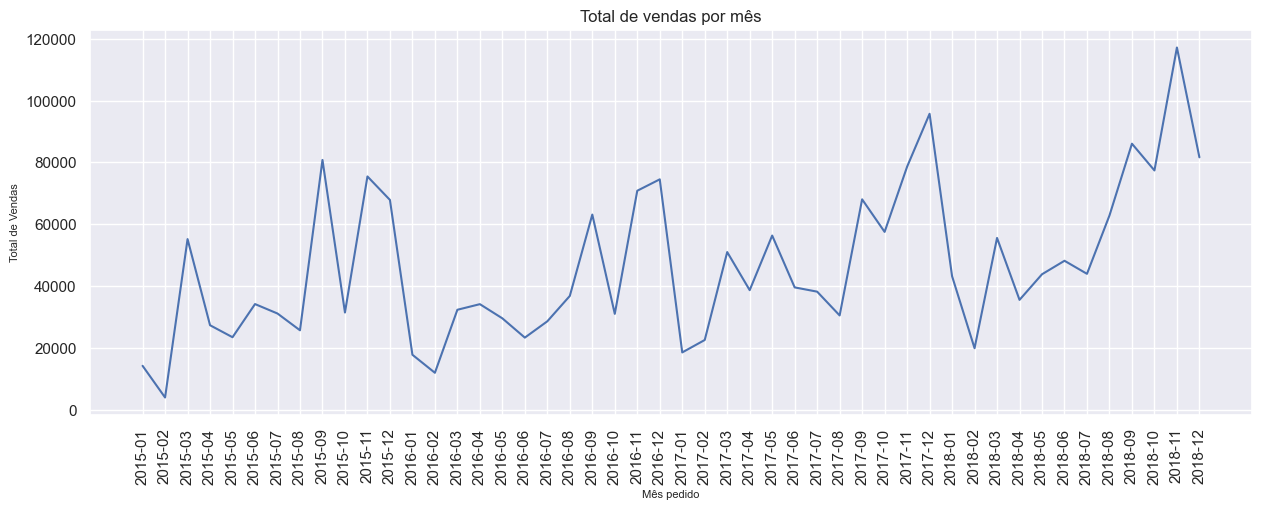

In [12]:
# convertendo coluna 'Data_Pedido' para datetime
df['Data_Pedido'] = pd.to_datetime(df['Data_Pedido'], format='%d/%m/%Y')

# criando coluna de mes/ano no formato 'YYYY-mm' para agrupar o total de vendas
df['Mes_Pedido'] = df['Data_Pedido'].dt.strftime('%Y-%m')

# agrupando o total de vendas por mes via SQL e salvando em um novo dataframe
query = """SELECT
            Mes_Pedido,
            SUM(Valor_Venda) as Total_Vendas
           FROM df
           GROUP BY Mes_Pedido"""

# retorna um dataframe a partir da query
df_vendas_mes = sqldf(query)

# setando objeto fig e ax para manipulação do gráfico
fig, ax = plt.subplots(figsize=(15, 5))

# configurando o gráfico
sns.lineplot(x=df_vendas_mes['Mes_Pedido'], y=df_vendas_mes['Total_Vendas'])
plt.xlabel('Mês pedido', fontsize=8)
plt.ylabel('Total de Vendas', fontsize=8)
plt.title('Total de vendas por mês')

# exibe os valores no eixo x rotacionados em 90 graus
plt.xticks(rotation=90)

# plt.tightp_layout()
plt.show()

Podemos observar um padrão nas vendas: em todos os anos os picos de vendas ocorrem sempre no último trimestre, seguidos de uma queda expressiva nos primeiros meses do ano subsequente.

## Pergunta de Negócio 3:

### Qual o Total de Vendas por Estado?

Demonstre o resultado através de um gráfico de barras.

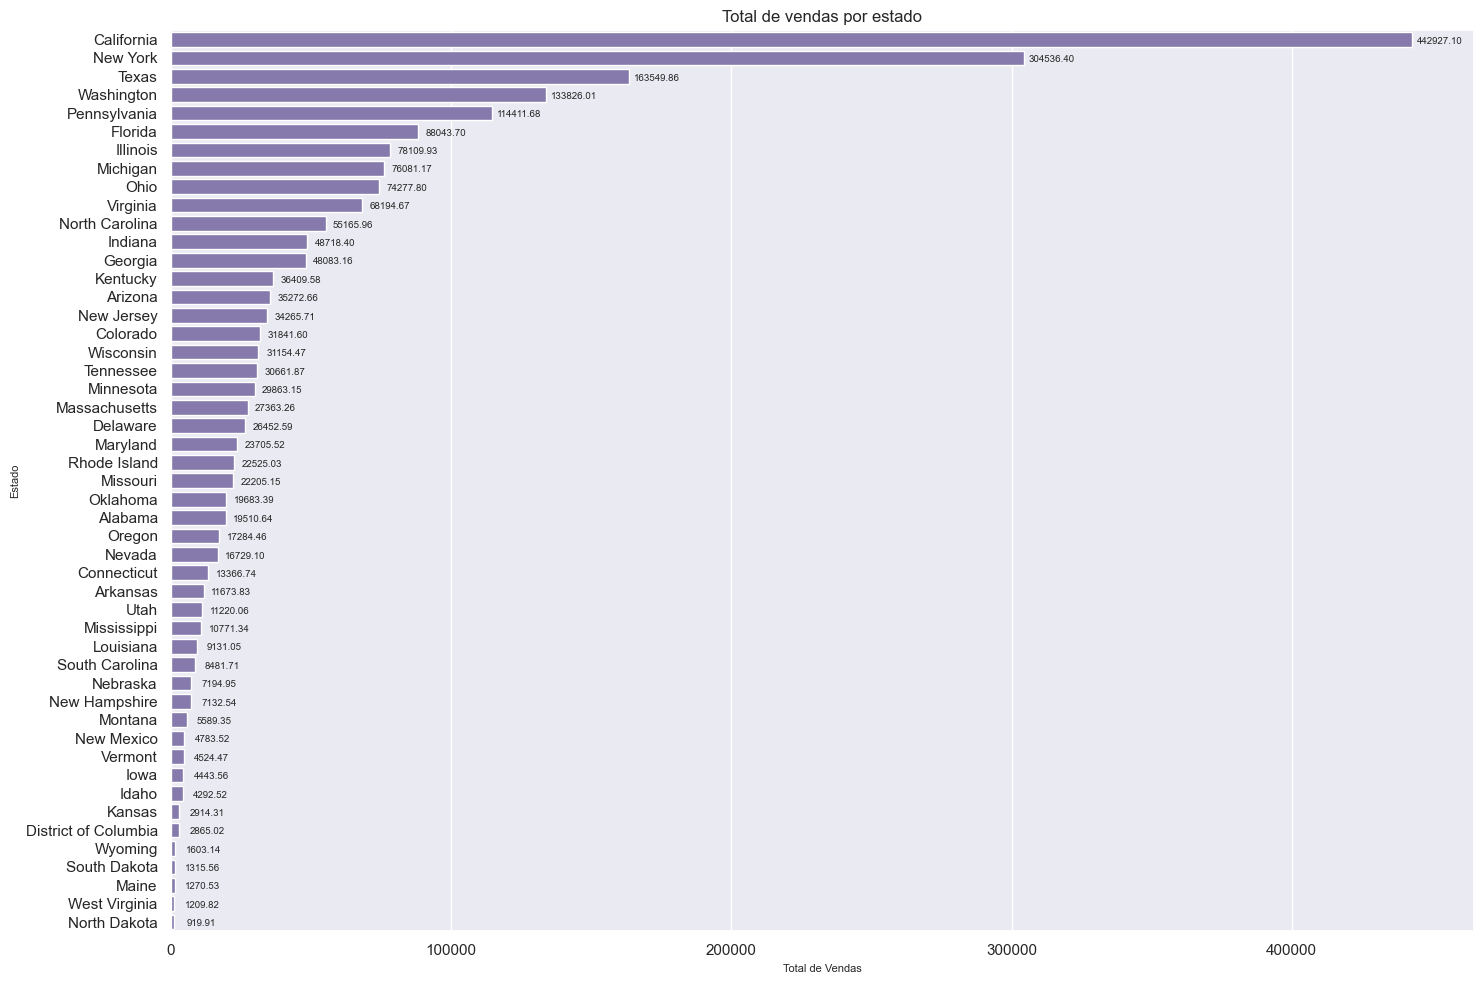

In [35]:
# agrupando as vendas por estado e ordenando pelo total de vendas
df_vendas_estado = df.groupby(by='Estado')['Valor_Venda'].sum().reset_index()\
                                                               .sort_values(by='Valor_Venda', ascending=False)

# configurando plot
fig, ax = plt.subplots(figsize=(15, 10))

# plotando o gráfico
sns.barplot(x='Valor_Venda', y='Estado', data=df_vendas_estado, orient='h', color='m')
plt.ylabel('Estado', fontsize=8)
plt.xlabel('Total de Vendas', fontsize=8)
plt.title('Total de vendas por estado')

# configurando os rotulos 
for x, y in zip(df_vendas_estado['Valor_Venda'], df_vendas_estado['Estado']):

    plt.annotate(text=f'{x:.2f}',               # o parametro 'text' recebe o valor para colocar nos rótulos (aqui estamos formatando y pra 2 casas decimais)
                 xy=(x, y),                     # parametro 'xy' recebe no formato de tupla o par ordenado (x, y) 
                 xytext=(20,-3),                  # xytext representam as coordenadas onde o texto será posicionado. (0, y) representa y unidades acima do ponto 
                 textcoords='offset points',    # Offset, em pontos, do valor xy
                 ha='center',                   # alinhamento do texto
                 size=7                         # tamanho da fonte
            )

plt.tight_layout()
plt.show()


O estado com o maior valor de venda é a Califórnia, com cerca de $443.000

## Pergunta de Negócio 4:

### Quais São as 10 Cidades com Maior Total de Vendas?

Demonstre o resultado através de um gráfico de barras.

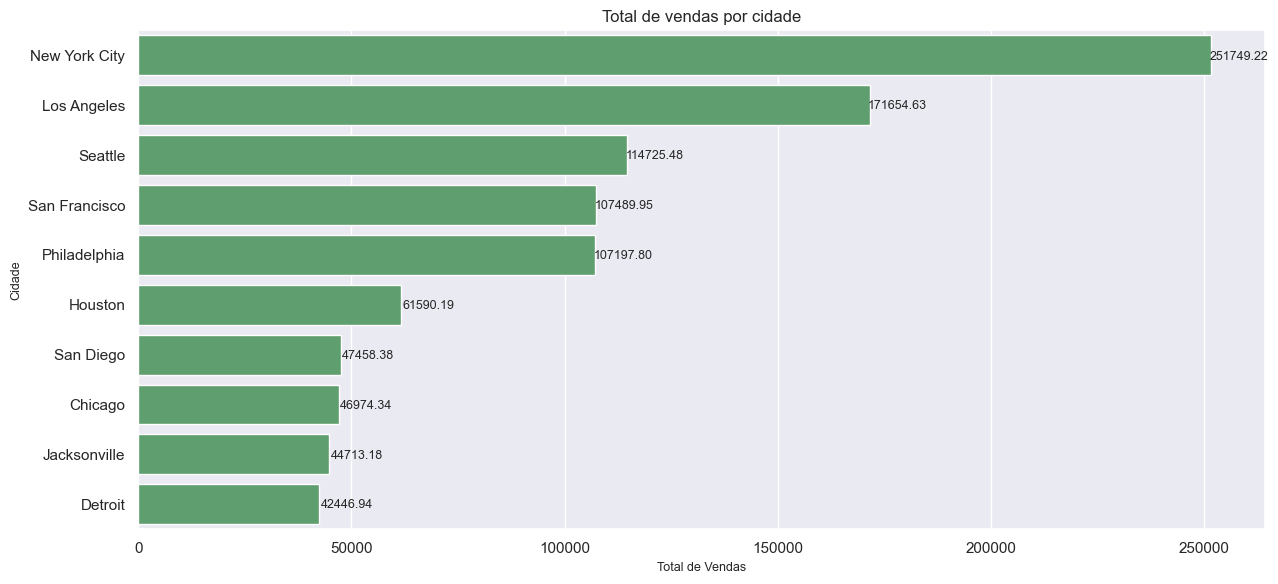

In [ ]:
query = """SELECT
            Cidade,
            SUM(Valor_Venda) as Total_Vendas
           FROM df
           GROUP BY Cidade
           ORDER BY Total_Vendas DESC
           LIMIT 10"""

df_top_10 = sqldf(query)

# configurando plot
fig, ax = plt.subplots(figsize=(13, 6))

# plotando o gráfico
sns.barplot(x=df_top_10['Total_Vendas'], y=df_top_10['Cidade'], orient='h', color='g')
plt.ylabel('Cidade', fontsize=9)
plt.xlabel('Total de Vendas', fontsize=9)
plt.title('Total de vendas por cidade')

# configurando os rotulos 
for x, y in zip(df_top_10['Total_Vendas'], df_top_10['Cidade']):

    plt.annotate(text=f'{x:.2f}',               # o parametro 'text' recebe o valor para colocar nos rótulos (aqui estamos formatando y pra 2 casas decimais)
                 xy=(x, y),                     # parametro 'xy' recebe no formato de tupla o par ordenado (x, y) 
                 xytext=(20,-3),                # xytext representam as coordenadas onde o texto será posicionado. (0, y) representa y unidades acima do ponto 
                 textcoords='offset points',    # Offset, em pontos, do valor xy
                 ha='center',                   # alinhamento do texto
                 size=9                         # tamanho da fonte
            )

plt.tight_layout()
plt.show()

## Pergunta de Negócio 5:

### Qual Segmento Teve o Maior Total de Vendas?

Demonstre o resultado através de um gráfico de pizza.

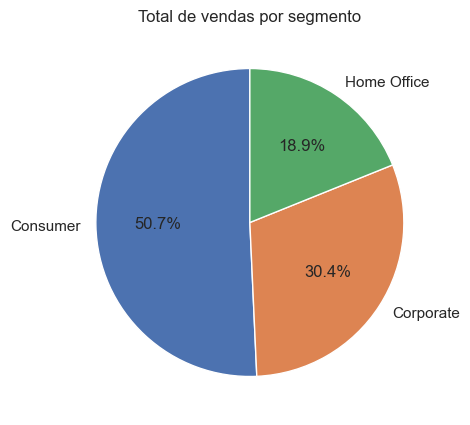

In [49]:
# agrupando o total de vendas por segmento
df_vendas_segmento = df.groupby(by='Segmento')['Valor_Venda'].sum().reset_index()

# configurando plot
fig, ax = plt.subplots(figsize=(8, 5))

# plotando o gráfico
ax.pie(x=df_vendas_segmento['Valor_Venda'], labels=df_vendas_segmento['Segmento'], autopct='%1.1f%%', startangle=90)

plt.title('Total de vendas por segmento')
plt.show()

O segmento com maior valor de vendas foi 'Consumer'.

## Pergunta de Negócio 6:

### Qual o Total de Vendas Por Segmento e Por Ano?

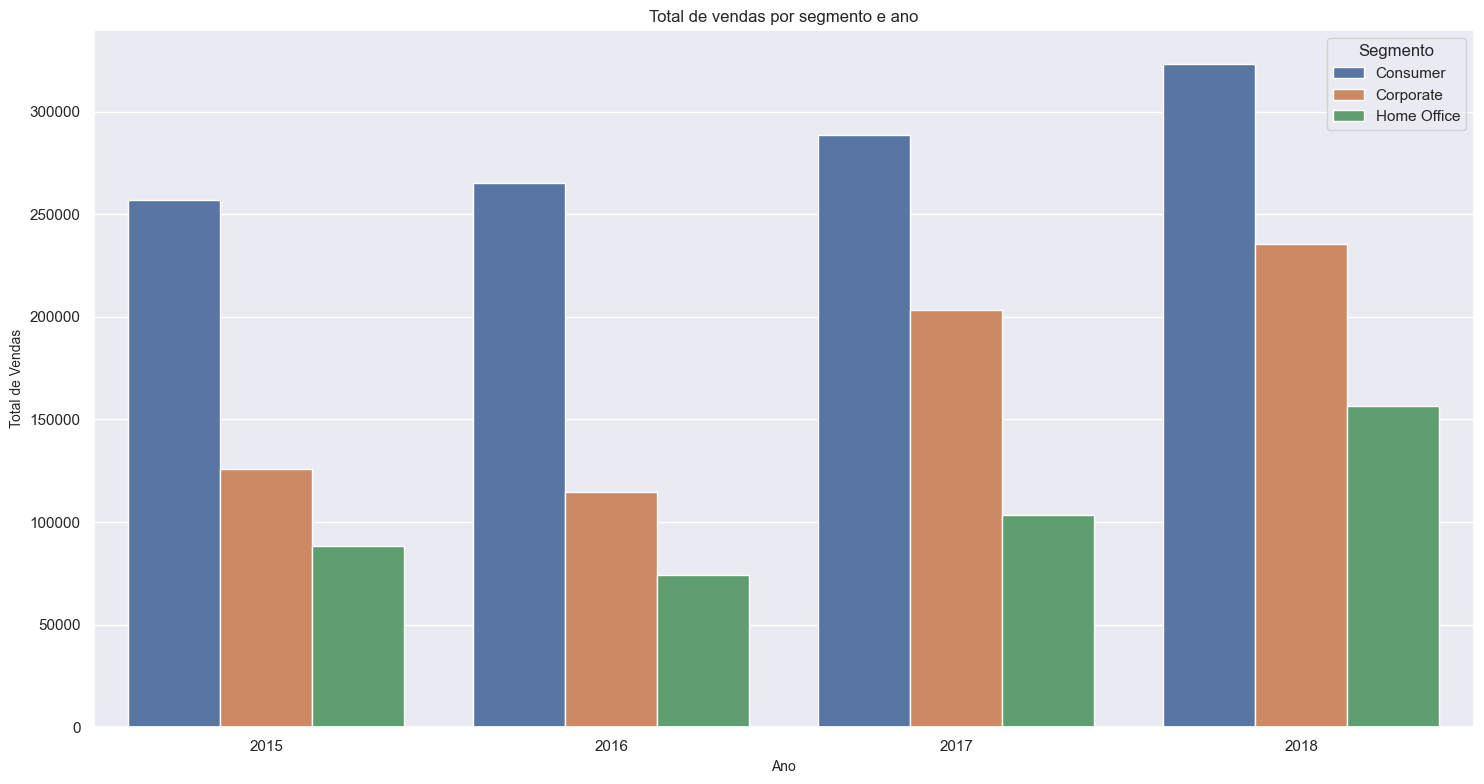

In [60]:
# extraindo o ano da coluna 'Data_Pedido'
df['Ano'] = df['Data_Pedido'].dt.year

# agrupando por segmento e ano
df_vendas_ano_segmento = df.groupby(by=['Ano', 'Segmento'])['Valor_Venda'].sum().reset_index()

# plotando gráfico de colunas
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x='Ano', y='Valor_Venda', hue='Segmento', data=df_vendas_ano_segmento)
plt.xlabel('Ano', fontsize=10)
plt.ylabel('Total de Vendas', fontsize=10)
plt.title('Total de vendas por segmento e ano')

for x, y in zip(df_vendas_ano_segmento['Ano'], df_vendas_ano_segmento['Valor_Venda']):

    plt.annotate(text=f'{y:.2f}',             
                 xy=(x, y),                  
                 xytext=(0,5),                
                 textcoords='offset points', 
                 ha='center',                
                 size=8                      
            )

plt.tight_layout()
plt.show()



O comportamento é o mesmo para os 4 anos de dados: O segmento de consumer lidera as vendas, enquanto o de home office é o que apresenta menor valor anual de vendas. 

Além disso, o segmento de consumer sempre apresentou crescimento em relação ao ano anterior, enquanto os demais segmentos apresentaram queda no ano de 2016.

## Pergunta de Negócio 7:

Os gestores da empresa estão considerando conceder diferentes faixas de descontos e gostariam de fazer uma simulação com base na regra abaixo:

- Se o Valor_Venda for maior que 1000 recebe 15% de desconto.
- Se o Valor_Venda for menor que 1000 recebe 10% de desconto.

### Quantas Vendas Receberiam 15% de Desconto?

In [70]:
query = """SELECT
            ID_Pedido,
            CASE 
                WHEN Valor_Venda > 1000 THEN '15'
                WHEN Valor_Venda < 1000 THEN '10'
                ELSE 'N/A'
            END as Faixa_Desconto
           FROM df"""

df_faixa_desconto = sqldf(query)

# qtd de vendas que receberiam 15% de desconto
qtd_vendas_15 = df_faixa_desconto.query("Faixa_Desconto == '15'").shape[0]

print(f'Quantidade de vendas que receberiam 15% de desconto seria {qtd_vendas_15} vendas')

Quantidade de vendas que receberiam 15% de desconto seria 457 vendas


## Pergunta de Negócio 8:

### Considere Que a Empresa Decida Conceder o Desconto de 15% do Item Anterior. Qual Seria a Média do Valor de Venda Antes e Depois do Desconto?

In [72]:
query = """SELECT
             AVG(Valor_Venda) as Media_Valor_Venda,
             AVG(CASE 
                    WHEN Valor_Venda > 1000 THEN Valor_Venda - Valor_Venda * 0.15
                    ELSE Valor_Venda
                 END) AS Media_Valor_Venda_Desconto
            FROM df"""

df_media_desconto = sqldf(query)
df_media_desconto

,Media_Valor_Venda,Media_Valor_Venda_Desconto
0,230.469892,215.51039


In [73]:
# usando a sintaxe do pandas

# valor antes do desconto
df_media_venda = df['Valor_Venda'].mean()

# valor depois do desconto
df_media_venda_desconto = np.where(df['Valor_Venda'] > 1000, 
                                   df['Valor_Venda'] - df['Valor_Venda'] * 0.15, 
                                   df['Valor_Venda'])\
                            .mean()

print(f'Media de vendas sem desconto: {df_media_venda:.2f}\nMedia de vendas com desconto: {df_media_venda_desconto:.2f}')

Media de vendas sem desconto: 230.47
Media de vendas com desconto: 215.51


A média dos valores de venda antes e após o desconto são respectivamente 230.47 e 215.51

## Pergunta de Negócio 9:

### Qual o Média de Vendas Por Segmento, Por Ano e Por Mês?

Demonstre o resultado através de gráfico de linha.

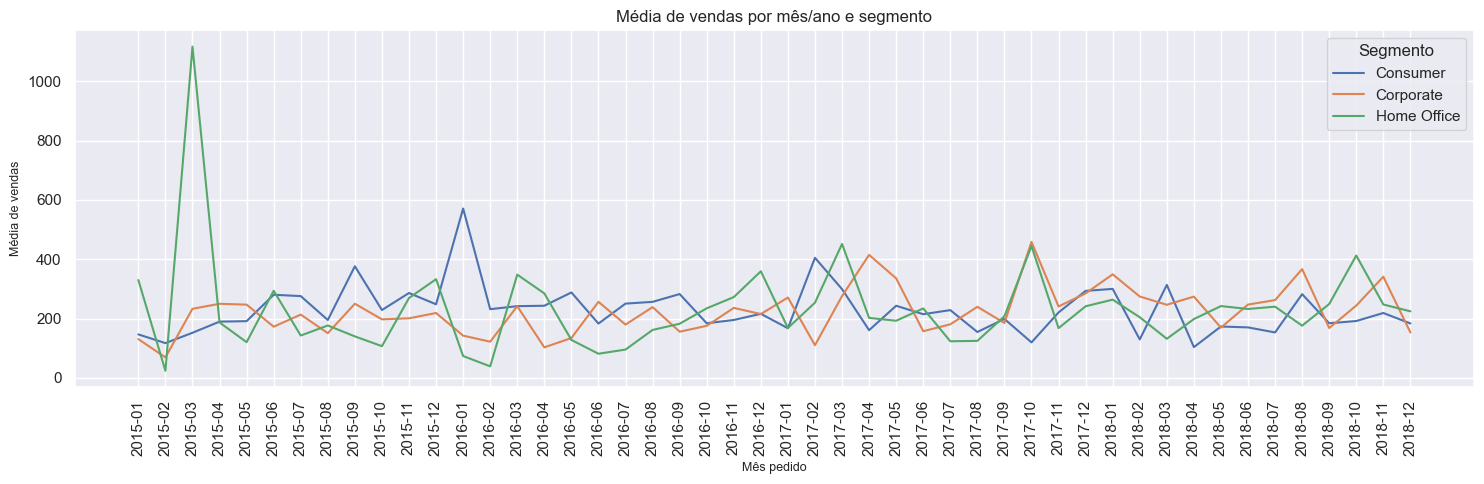

In [77]:
# agrupando avg de valor de venda por mes/ano e segmento
df_avg_vendas_mes_ano = df.groupby(by=['Mes_Pedido', 'Segmento'])['Valor_Venda'].mean().reset_index()

# criando objetos fig e ax
fig, ax = plt.subplots(figsize=(15, 5))

# plotando o gráfico
sns.lineplot(data=df_avg_vendas_mes_ano, x='Mes_Pedido', y='Valor_Venda', hue='Segmento')
plt.xlabel('Mês pedido', fontsize=9)
plt.ylabel('Média de vendas', fontsize=9)
plt.title('Média de vendas por mês/ano e segmento')
plt.xticks(rotation=90) # rotacionando os valores do eixo x em 90 graus para não se sobreporem

plt.tight_layout()
plt.show()

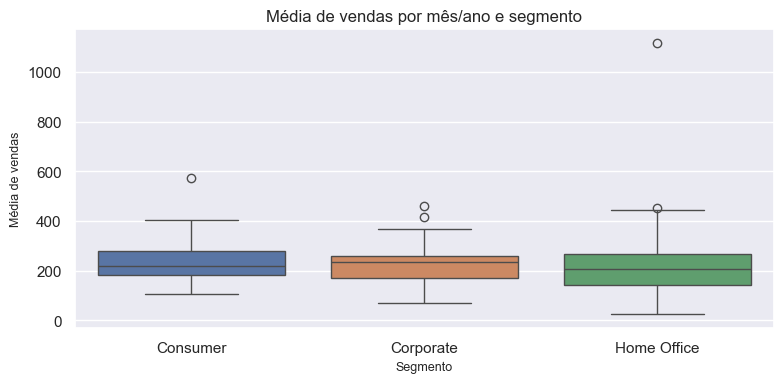

In [86]:
# avaliando a dispersão dos valores de vendas mensal por segmento
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_avg_vendas_mes_ano, x='Segmento', y='Valor_Venda', hue='Segmento')
plt.xlabel('Segmento', fontsize=9)
plt.ylabel('Média de vendas', fontsize=9)
plt.title('Média de vendas por mês/ano e segmento')

plt.tight_layout()
plt.show()


Pelo box plot percebe-se que o segmento 'Consumer' tem uma concentração de meses com valores médios próximos à 200.00. Já o de corporate, apresenta valores médios mais concentrados um pouco acima de 200.00. Por fim, o segmento de home office é o que apresenta uma distribuição de valores mais simétricos

## Pergunta de Negócio 10:

### Qual o Total de Vendas Por Categoria e SubCategoria, Considerando Somente as Top 3 SubCategorias de cada categoria? 

Demonstre tudo através de um único gráfico.

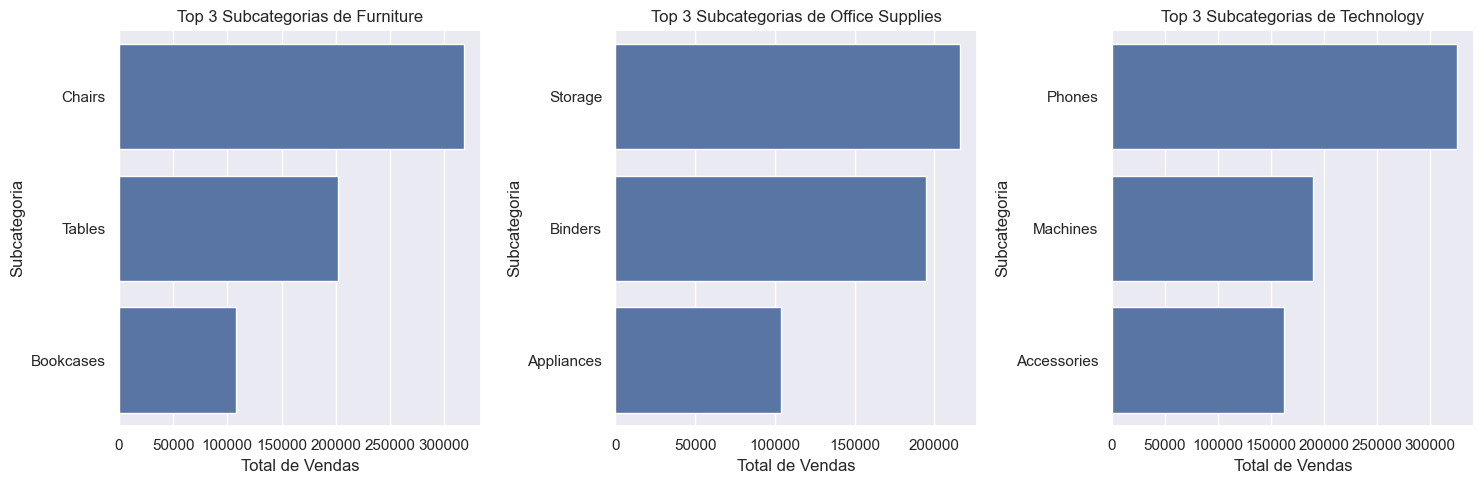

In [103]:
query = """SELECT
              Categoria,
              SubCategoria,
              DENSE_RANK() OVER (PARTITION BY Categoria ORDER BY SUM(Valor_Venda) DESC) as Rank,
              SUM(Valor_Venda) as Total_Vendas
            FROM df
             GROUP BY 
              Categoria, 
              SubCategoria"""

# criando um dataframe a partir da query com o top 3
df_rank = sqldf(query).query("Rank <= 3")

# configurando 3 plots, um para cada categoria
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# fazendo o plot de cada categoria
for i, categoria in enumerate(df_rank['Categoria'].unique()):
    sns.barplot(x='Total_Vendas', y='SubCategoria', data=df_rank.query(f"Categoria == '{categoria}'"), ax=axes[i], orient='h')
    axes[i].set_title(f'Top 3 Subcategorias de {categoria}')
    axes[i].set_xlabel('Total de Vendas')
    axes[i].set_ylabel('Subcategoria')

plt.tight_layout()
plt.show()

## Pergunta de Negócio 11:

### Qual o Total de Vendas Por Categoria e SubCategoria, Considerando Somente as Top 12 SubCategorias? 

Demonstre tudo através de um único gráfico.

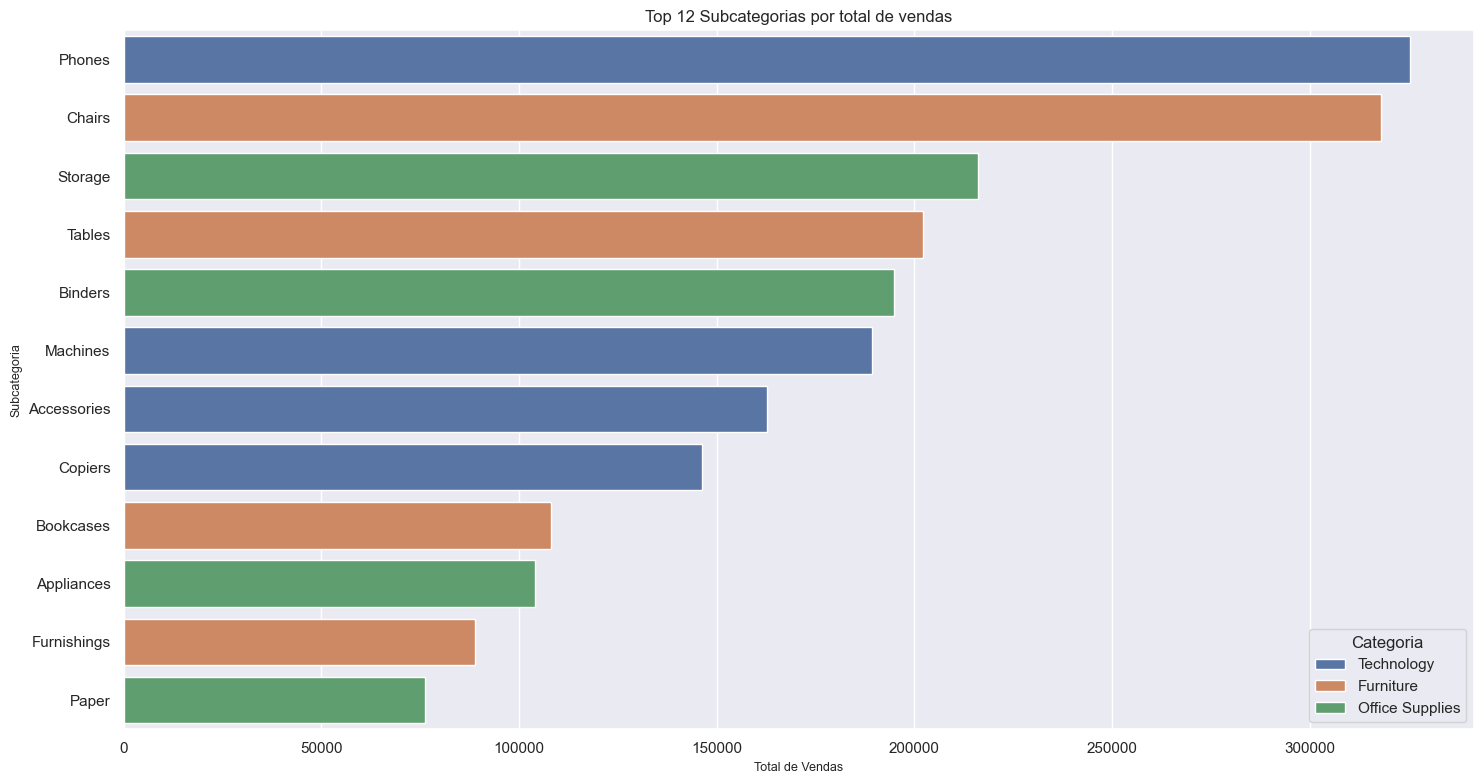

In [105]:
# agrupando e ordenando por total de vendas
df_groupby = df.groupby(by=['Categoria', 'SubCategoria'])['Valor_Venda'].sum()\
                                                                        .reset_index()\
                                                                        .sort_values(by='Valor_Venda', ascending=False)

# criando o rank de vendas e filtrando top 12
df_groupby['rank'] = df_groupby['Valor_Venda'].rank(ascending=False, method='dense')
df_groupby = df_groupby.query("rank <= 12")

# configurando plot
fig, ax = plt.subplots(figsize=(15, 8))

# plotando o gráfico
sns.barplot(x='Valor_Venda', y='SubCategoria', hue='Categoria', data=df_groupby, orient='h')
plt.xlabel('Total de Vendas', fontsize=9)
plt.ylabel('Subcategoria', fontsize=9)
plt.title('Top 12 Subcategorias por total de vendas')

# ajustando o layout e exibindo o gráfico
plt.tight_layout()
plt.show()